## 그래디언트 부스팅 노트 필사

In [ ]:
#fastai 콘다 환경에서 먼저 설치 해주자 torch 랑

In [3]:
!pip install fastai


  Using cached fastai-2.2.5-py3-none-any.whl (191 kB)
  Using cached fastprogress-1.0.0-py3-none-any.whl (12 kB)
  Using cached spacy-3.0.3-cp37-cp37m-win_amd64.whl (11.6 MB)
  Using cached torchvision-0.5.0-cp37-cp37m-win_amd64.whl (1.2 MB)
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19191 sha256=49014e1e5e89dfc6fcb553d2564e0dab80ebaf6b2a3145c9a9ebd0e7943ba62a
  Stored in directory: c:\users\82102\appdata\local\pip\cache\wheels\df\99\da\c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=cb56b10d81f08da4c7f1176618e35025a7f886295ca1a9d394a730f7828ab483
  Stored in directory: c:\users\82102\appdata\local\pip\cache\wheels\83\a6\12\bf3c1a667bde4251be5b7a3368b2d604c9af2105b5c1cb1870
Successfully built nvidia-ml-py3 smart-open


In [4]:
%matplotlib inline

import numpy as np 
import pandas as pd
from IPython.display import display
from fastai.imports import *
from sklearn import metrics

In [5]:
pip freeze

absl-py @ file:///tmp/build/80754af9/absl-py_1607439979954/work
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613038019788/work
asgiref==3.3.1
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astor==0.8.1
astroid @ file:///C:/ci/astroid_1592481955828/work
astropy @ file:///C:/ci/astropy_1606919052914/work
async-generator==1.10
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1613246362269/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.shutil-get-terminal-size @ file:///tmp/build/80754af9/backports.shutil_get_terminal_size_1608222128777/work
backtrader==1.9.76.123
bcrypt @ file:///C:/ci/bcrypt_1597918112552/work
beautifulsoup4 @

## 결정트리 클래스

In [28]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs = np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf= x,y,idxs,min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
        
    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

## 데이터 시뮬레이션

In [20]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

In [13]:
# 랜덤 균일 분포

y1 = np.random.uniform(10, 15, 10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4, y5))
y = y[:,None] #길이를 1로만들어주는 혜자 코드

In [21]:
# scattere plot 
x.shape, y.shape

((50, 1), (50, 1))

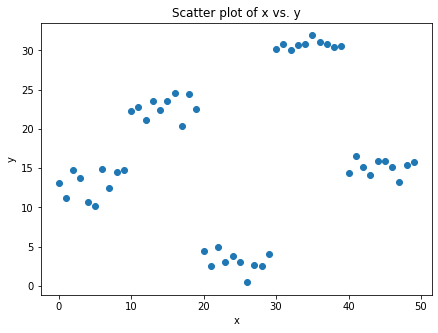

In [22]:
plt.figure(figsize = (7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Gradient Boosting (Decision Trees in a loop)

In [24]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

C:\Users\82102\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


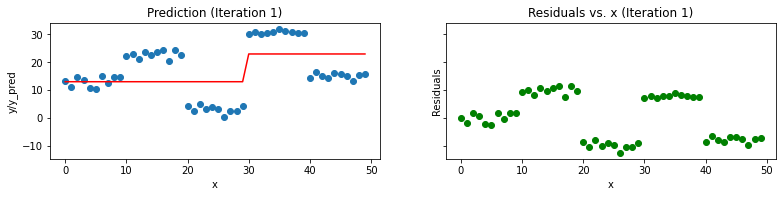

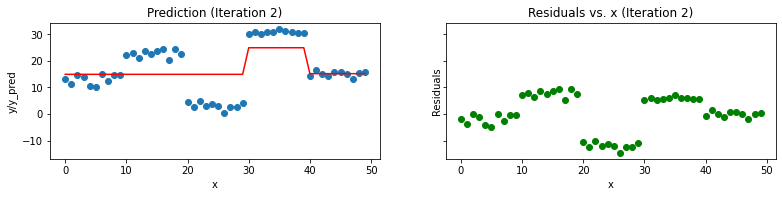

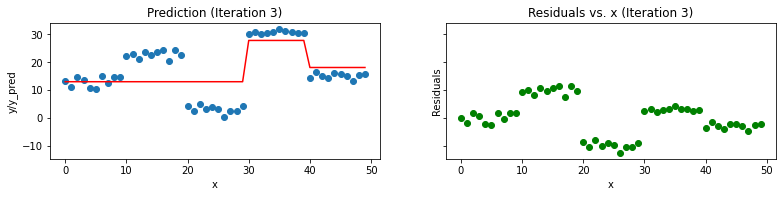

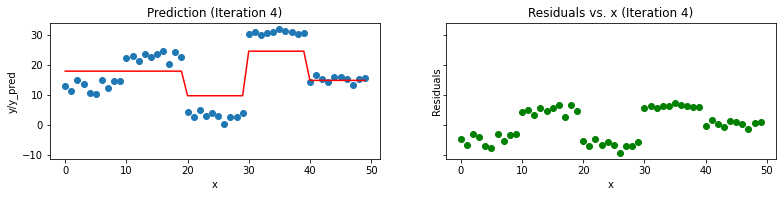

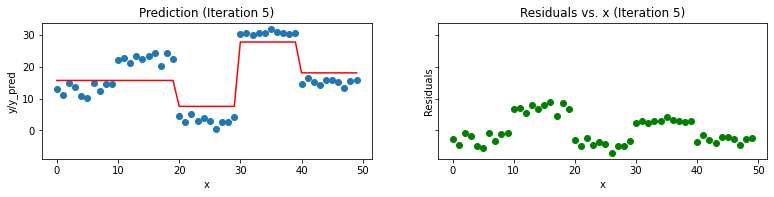

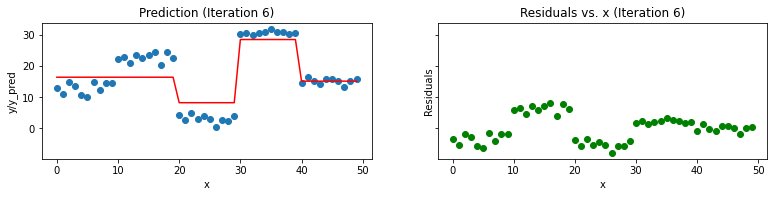

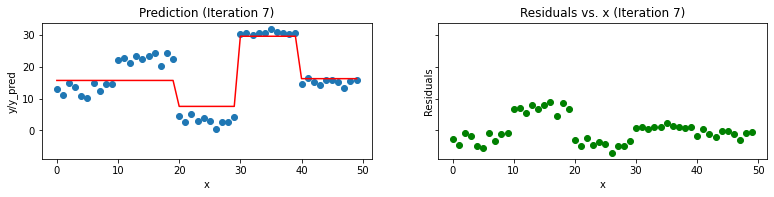

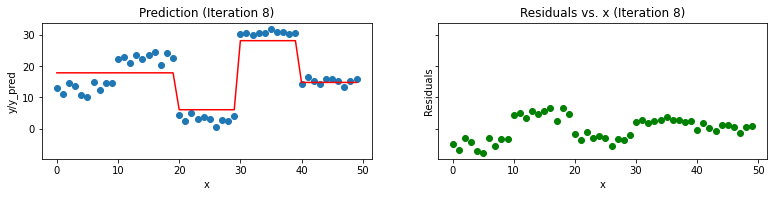

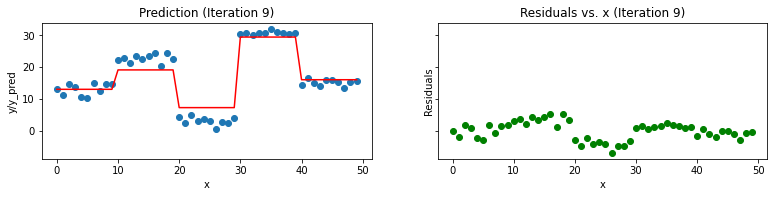

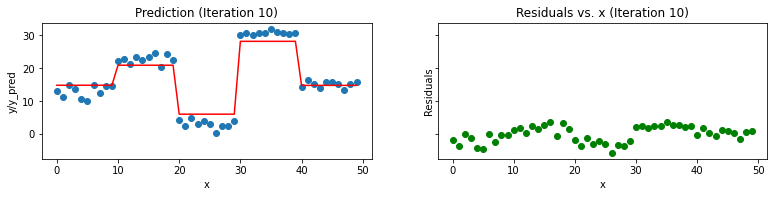

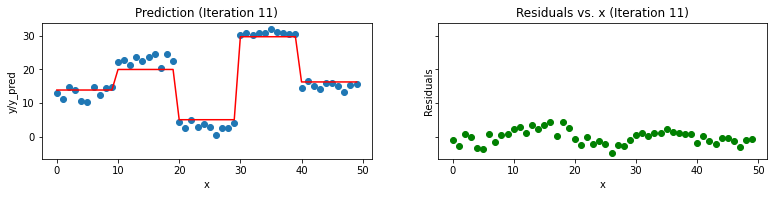

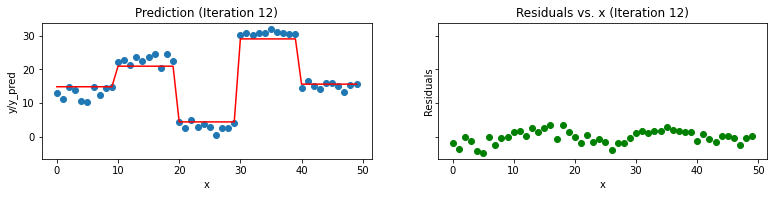

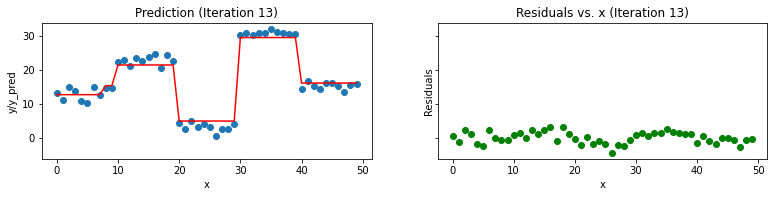

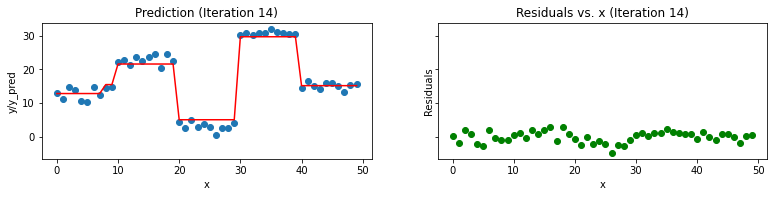

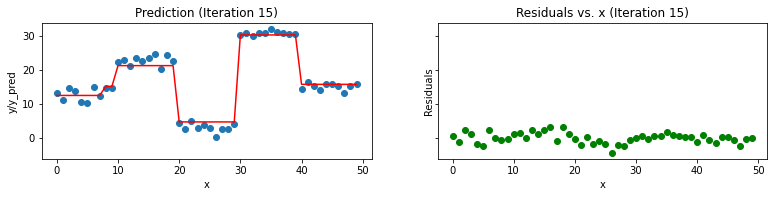

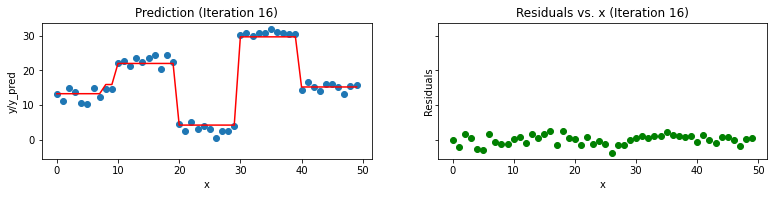

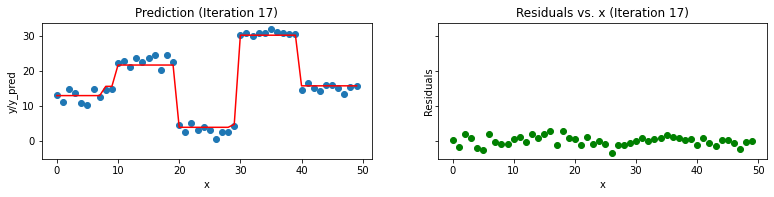

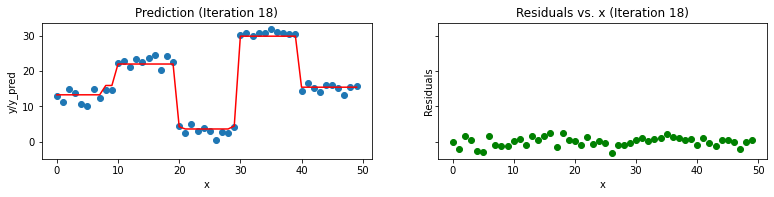

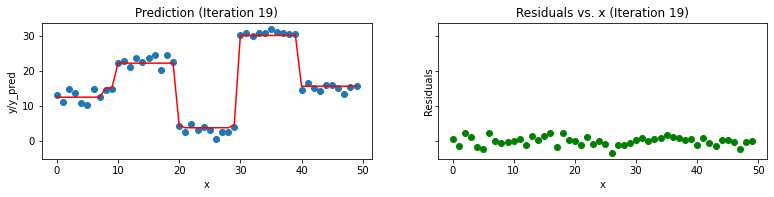

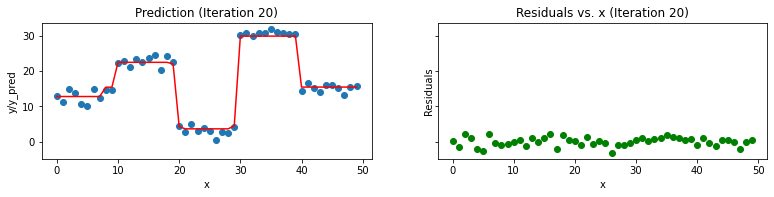

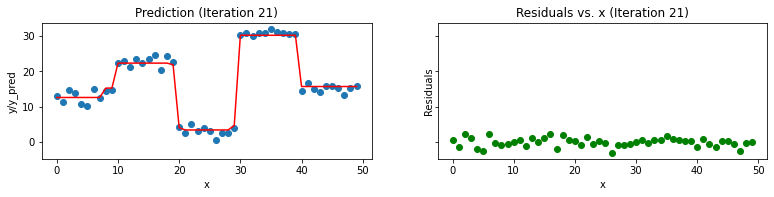

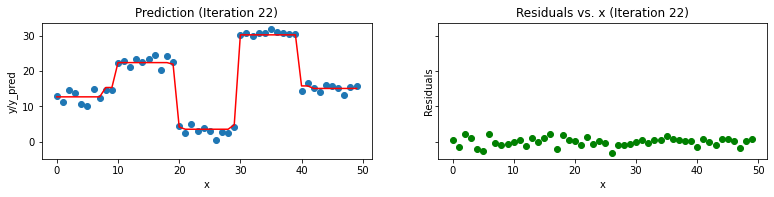

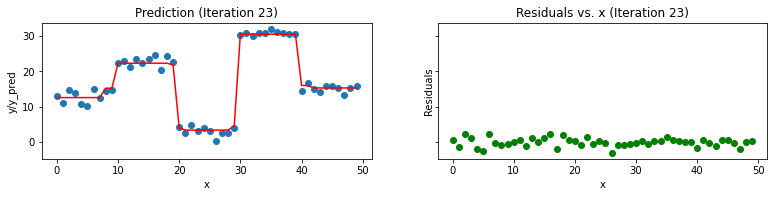

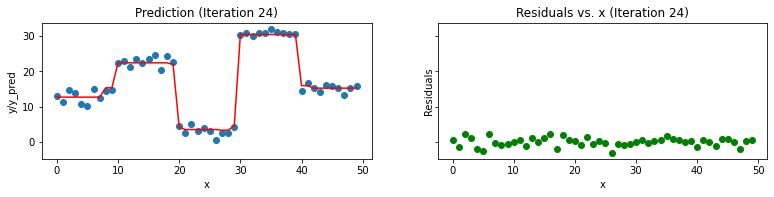

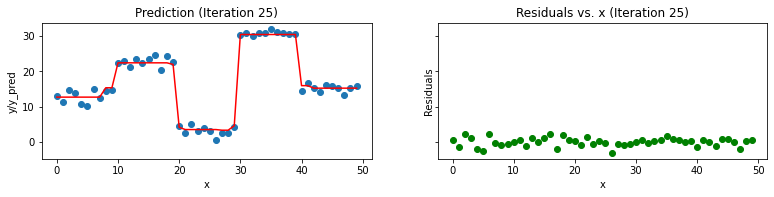

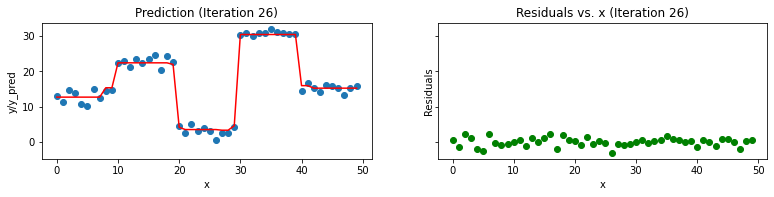

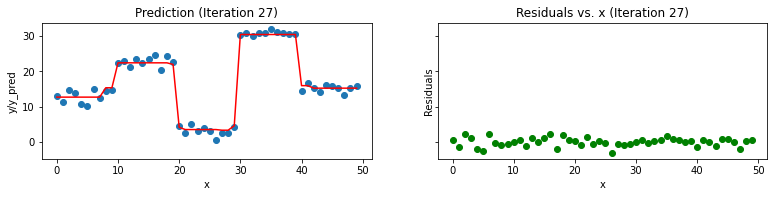

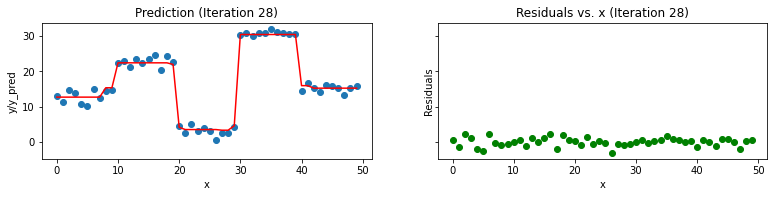

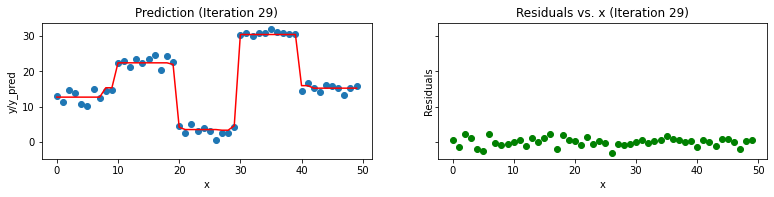

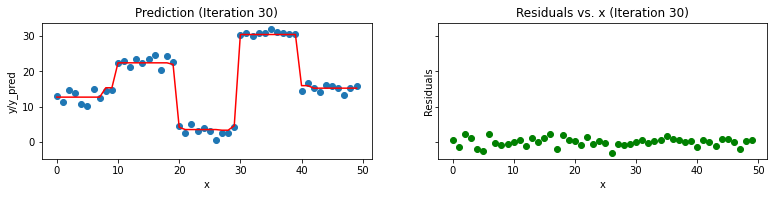

In [32]:
xi = x #입력값 초기화
yi = y #타겟값 초기화
ei = 0 #에러 값 초기화
n = len(yi) #열 길이
predf = 0 #예측값 초기화

for i in range(30): 
    tree = DecisionTree(xi, yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r)) 
    #replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), r))
    #replace right side mean y
    
    predi = predi[:, None] #make long vector 길이 1인 벡터
    
    predf = predf +predi #최종 예측값 , 이전 예측값 + 새 잔차 예측값
    
    ei = y - predf #y의 잔차 값
    yi = ei 
    
    # plotting after prediction
    
    xa = np.array(x.x) #컬럼이름
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))
    
    ax1.plot(x,y,'o')
    ax1.plot(xs,ys,'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y/y_pred')
    
    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')
    

In [33]:
pip freeze

absl-py @ file:///tmp/build/80754af9/absl-py_1607439979954/workNote: you may need to restart the kernel to use updated packages.
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613038019788/work
asgiref==3.3.1
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astor==0.8.1
astroid @ file:///C:/ci/astroid_1592481955828/work
astropy @ file:///C:/ci/astropy_1606919052914/work
async-generator==1.10
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1613246362269/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.shutil-get-terminal-size @ file:///tmp/build/80754af9/backports.shutil_get_terminal_size_1608222128777/work
backtrader==1.9.76.123
